# COBA and CUBA networks

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/COBA.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/COBA.ipynb)

In [1]:
#!pip install ANNarchy

This notebook reproduces the benchmarks used in:

> Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., *J. Comput. Neurosci., 23, 3, 349–98*

They are based on the balanced network proposed by: 

> Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., *J. Neurosci., 25, 46, 10786–95*

Each network is composed of 4000 neurons (3200 excitatory and 800 inhibitory), reciprocally connected with a probability of 0.02 (sparse connection).

The CUBA network uses a current-based integrate-and-fire neuron model:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) - g_\text{inh} (t)$$

while the COBA model uses conductance-based IF neurons:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) * (E_\text{exc} - v(t)) + g_\text{inh} (t) * (E_\text{inh} - v(t)) + I(t)$$
    
Apart from the neuron model and synaptic weights, both networks are equal, so we'll focus on the COBA network here.

The discretization step has to be set to 0.1 ms:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ANNarchy 5.0 (5.0.0) on linux (posix).


## Neuron definition

In [3]:
COBA = ann.Neuron(
    parameters = dict(
        El = -60.0,
        Vr = -60.0,
        Erev_exc = 0.0,
        Erev_inh = -80.0,
        Vt = -50.0,
        tau = 20.0,
        tau_exc = 5.0,
        tau_inh = 10.0,
        I = 20.0,
    ),
    equations=[
        'tau * dv/dt = (El - v) + g_exc * (Erev_exc - v) + g_inh * (Erev_inh - v ) + I',
        'tau_exc * dg_exc/dt = - g_exc',
        'tau_inh * dg_inh/dt = - g_inh',
    ],
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

In [4]:
CUBA = ann.Neuron(
    parameters = dict(
        El = -49.0,
        Vr = -60.0,
        Vt = -50.0,
        tau_m = 20.0,
        tau_exc = 5.0,
        tau_inh = 10.0,
    ),
    equations = [
        'tau_m * dv/dt = (El - v) + g_exc - g_inh',
        'tau_exc * dg_exc/dt = - g_exc',
        'tau_inh * dg_inh/dt = - g_inh',
    ],
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

The neurons define exponentially-decreasing conductance g_exc and g_inh for the excitatory and inhibitory conductances/currents, respectively. They also define a refractory period of 5 ms.

## Networks

Each network creates a population `P` of 4000 homogeneous neurons. It is implicitly split into excitatory (80%) and inhibitory (20%) subpopulations using `PopulationViews` and slicing.

The neurons are randomly connected with a probability of 0.02. Excitatory neurons project on all other neurons with the target "exc", while the inhibitory neurons have the target "inh". The weights values are uniform in all projections.

A monitor records the spikes in the whole population.

In [5]:
class COBANetwork (ann.Network):
    
    def __init__(self, w_exc, w_inh):

        self.P = self.create(geometry=4000, neuron=COBA)
        self.P.v     = ann.Normal(-55.0, 5.0)
        self.P.g_exc = ann.Normal(4.0,   1.5)
        self.P.g_inh = ann.Normal(20.0, 12.0)

        self.Ce = self.connect(pre=self.P[:3200], post=self.P, target='exc')
        self.Ce.fixed_probability(weights=w_exc, probability=0.02)

        self.Ci = self.connect(pre=self.P[3200:], post=self.P, target='inh')
        self.Ci.fixed_probability(weights=w_inh, probability=0.02)

        self.m = self.monitor(self.P, ['spike'])

In [6]:
class CUBANetwork (ann.Network):
    
    def __init__(self, w_exc, w_inh):

        self.P = self.create(geometry=4000, neuron=CUBA)
        self.P.v = ann.Uniform(-60.0, -50.0)

        self.Ce = self.connect(pre=self.P[:3200], post=self.P, target='exc')
        self.Ce.fixed_probability(weights=w_exc, probability=0.02)

        self.Ci = self.connect(pre=self.P[3200:], post=self.P, target='inh')
        self.Ci.fixed_probability(weights=w_inh, probability=0.02)

        self.m = self.monitor(self.P, ['spike'])

In [7]:
# COBA network
we_COBA = 0.6
wi_COBA = 6.7
net_coba = COBANetwork(w_exc=we_COBA, w_inh=wi_COBA, dt=0.1)
net_coba.compile()

# CUBA network
we_CUBA = 0.27 * 60.0 / 10.0 # 0.7 * (Vmean - E_rev_exc) / gL (mV)
wi_CUBA = 4.5 * 20.0 / 10.0 # 4.5 * (Vmean - E_rev_inh) / gL (mV)
net_cuba = CUBANetwork(w_exc = we_CUBA, w_inh=wi_CUBA, dt=0.1)
net_cuba.compile()

Compiling network 1...  

OK 


Compiling network 2...  

OK 


## Simulation

We can now simulate each network for 1 second:

In [8]:
net_coba.simulate(1000., measure_time=True)
net_cuba.simulate(1000., measure_time=True)

Simulating 1.0 seconds of the network 1 took 0.18157339096069336 seconds. 
Simulating 1.0 seconds of the network 2 took 0.12860608100891113 seconds. 


We retrieve the recorded spikes from the monitor:

In [9]:
data_COBA = net_coba.m.get('spike')
data_CUBA = net_cuba.m.get('spike')

and compute a raster plot from the data:

In [10]:
t_COBA, n_COBA = net_coba.m.raster_plot(data_COBA)
t_CUBA, n_CUBA = net_cuba.m.raster_plot(data_CUBA)

`t` and `n` are lists representing for each spike emitted during the simulation the time at which it was emitted and the index the neuron which fired. The length of this list represents the total number of spikes in the popultion, so we can compute the population mean firing rate:

In [11]:
print('Mean firing rate in the COBA population: ' + str(len(t_COBA) / 4000.) + 'Hz')
print('Mean firing rate in the CUBA population: ' + str(len(t_CUBA) / 4000.) + 'Hz')

Mean firing rate in the COBA population: 20.39775Hz
Mean firing rate in the CUBA population: 5.51925Hz


Finally, we can show the raster plot with matplotlib:

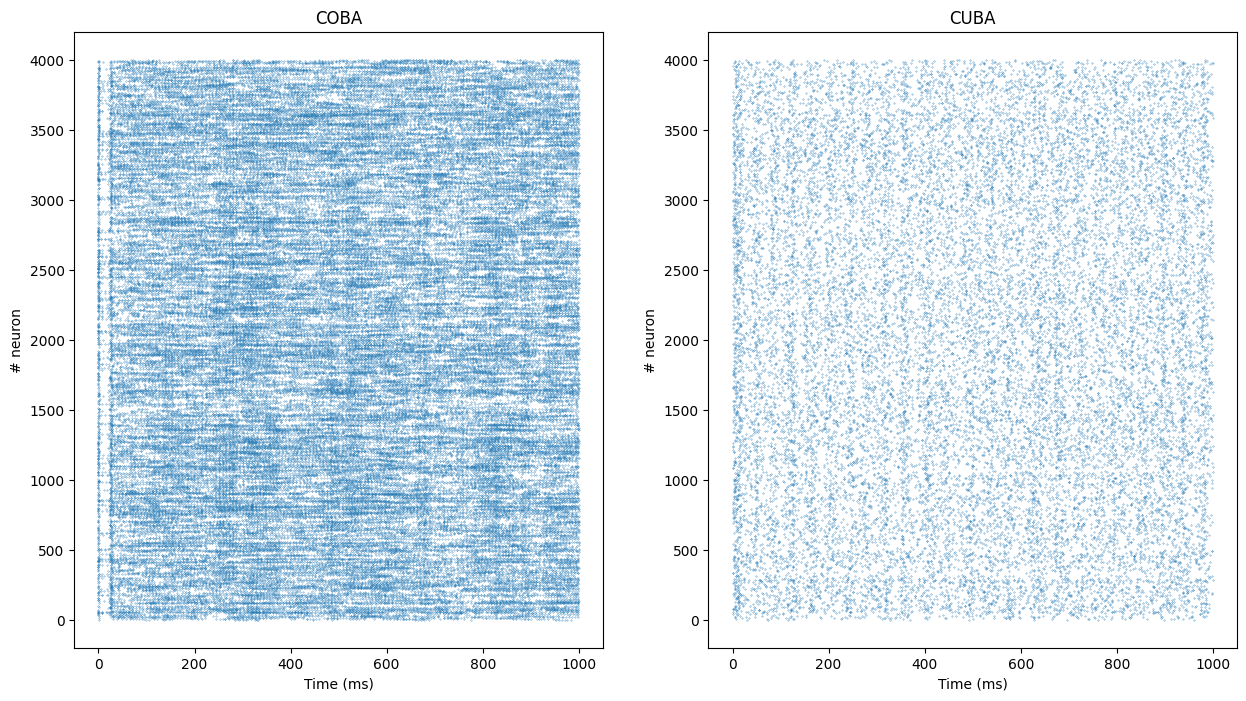

In [12]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("COBA")
plt.plot(t_COBA, n_COBA, '.', markersize=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.subplot(122)
plt.title("CUBA")
plt.plot(t_CUBA, n_CUBA, '.', markersize=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.show()

More detailed information about the activity of the population is provided by the inter-spike interval and the coefficient of variation, for both of which values we offer methods provided by the Monitor class.

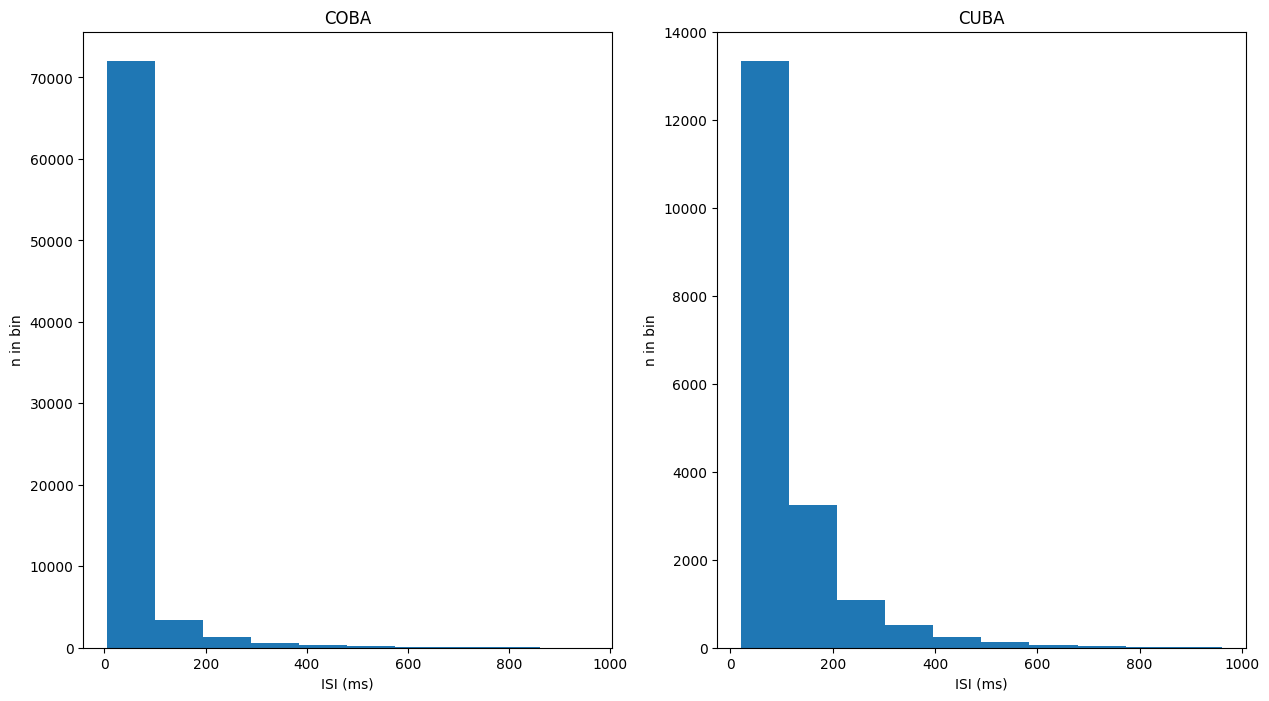

In [13]:
isi_COBA = net_coba.m.inter_spike_interval(data_COBA)
isi_CUBA = net_cuba.m.inter_spike_interval(data_CUBA)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("COBA")
plt.hist(isi_COBA)
plt.xlabel('ISI (ms)')
plt.ylabel('n in bin')
plt.subplot(122)
plt.title("CUBA")
plt.hist(isi_CUBA)
plt.xlabel('ISI (ms)')
plt.ylabel('n in bin')
plt.show()

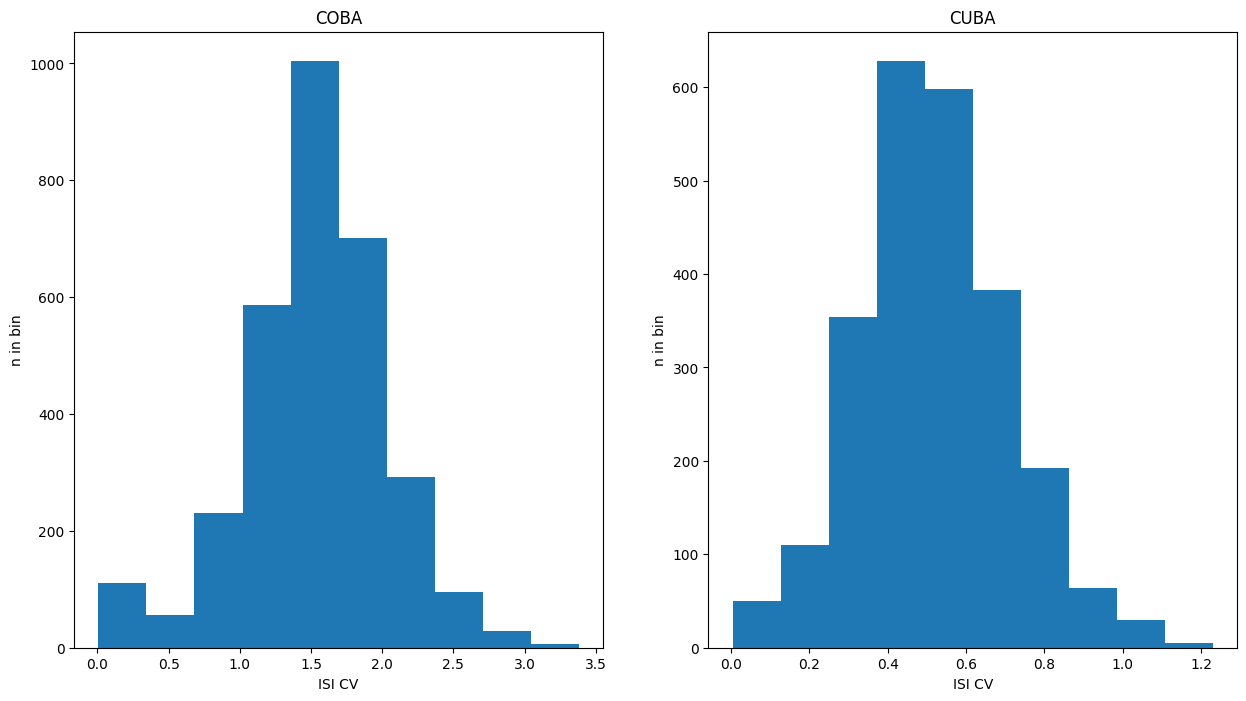

In [14]:
cov_COBA = net_coba.m.coefficient_of_variation(data_COBA)
cov_CUBA = net_cuba.m.coefficient_of_variation(data_CUBA)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("COBA")
plt.hist(cov_COBA)
plt.xlabel('ISI CV')
plt.ylabel('n in bin')
plt.subplot(122)
plt.title("CUBA")
plt.hist(cov_CUBA)
plt.xlabel('ISI CV')
plt.ylabel('n in bin')
plt.show()